In [1]:
import requests

requests.get('http://www.google.com', timeout=10).ok

True

In [2]:
%%capture

!pip install --upgrade kaggle-environments

In [3]:
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



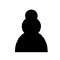
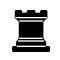
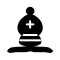
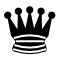
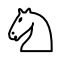
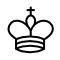
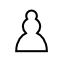
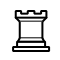
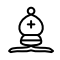
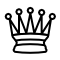
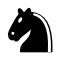
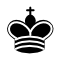

In [4]:
result = env.run(['random', 'random'])
env.render(mode='ipython', width=1000, height=1000)

In [5]:
%%writefile main.py

from Chessnut import Game
import time, random

def chessbot(obs):
    game = Game(obs.board)
    moves = list(game.get_moves())

    for move in moves[:10]:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return move

    for move in moves[:10]:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            return move

    for move in moves[:10]:
        if "q" in move.lower():
            return move

    return random.choice(moves)

Writing main.py


Agent exit status/reward/time left: 
	 DONE / 0.5 / 10
	 DONE / 0.5 / 10





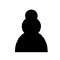
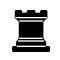
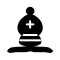
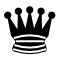
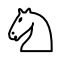
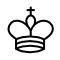
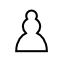
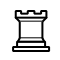
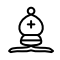
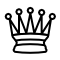
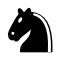
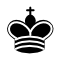

In [6]:
result = env.run(['main.py', 'random'])
print('Agent exit status/reward/time left: ')

for agent in result[-1]:
    print('\t', agent.status, '/', agent.reward, '/', agent.observation.remainingOverageTime)
print('\n')

env.render(mode='ipython', width=1000, height=1000)

# New attempt

### This code was stolen from Vyacheslav Bolotin, here is the kaggle link: https://www.kaggle.com/code/vyacheslavbolotin/chess-bot-starter-step-0-0-0-3?scriptVersionId=209647842

In [7]:
%%writefile Chess_bot_v2.py

import time, random
from Chessnut import Game

piece_sym = ['K', 'k', 'Q', 'q', 'R', 'r', 'B', 'b', 'N', 'n', 'P', 'p']
piece_val = [0, 0, 100, 100, 50, 50, 30, 30, 30, 30, 10, 10]
piece_val_dict = dict(zip(piece_sym, piece_val))

def evaluate_position(board):
    total_score = 0
    for square in range(64):
        piece = board.get_piece(square)
        if piece != ' ':
            piece_value = piece_val_dict.get(piece.upper(), 0)
            if piece.isupper():
                total_score += piece_value
            else:
                total_score -= piece_value
    return total_score

def make_move(move, time_to_start_thinking, is_execute_print=False):
    duration = round(time.time() - time_to_start_thinking, 3)
    if is_execute_print == True:
        print(f'[{move}, {duration}]')
    return move

def panic_mode(game, fen):
    moves = game.get_moves()
    for move in moves:
        game.apply_move(move)
        if game.status == Game.CHECKMATE:
            return move
        game.set_fen(fen)
    return random.choice(moves)

def Chess_bot_v2(obs):
    time_start = time.time()
    game = Game(obs.board)
    moves = list(game.get_moves())

    game = Game(fen=obs.board)
    if obs.remainingOverageTime < 2:
        return panic_mode(game, obs.board)

    evas, moves_eva, eva_init = [], [], evaluate_position(game.board)

    for move in moves:
        g = Game(obs.board)
        g.apply_move(move)
        eva_after = evaluate_position(g.board)
        moves_eva.append({
            'move': move,
            'max': eva_after - eva_init
        })
        evas.append(eva_after)

    if len(moves_eva) >= 1:
        moves_eva = sorted(moves_eva, key=lambda x: x['max'], reverse=True)
        max_move = moves_eva[0] if moves_eva != None and len(moves_eva) >= 1 else None
        if max_move != None:
            if max_move['max'] == 100:
                print(max_move)
                return make_move(max_move['move'], time_start)
            if max_move['max'] == 50:
                print(max_move)
                return make_move(max_move['move'], time_start)

    for move in moves:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return make_move(move,time_start)

    random.shuffle(moves)
    
    # 2. Check for captures
    for move in moves:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            #print(f'\n{move}\n')
            return make_move(move,time_start)

    # 3. Check for queen promotions
    for move in moves:
        if "q" in move.lower():
              #print(f'\n{move}\n')
            return make_move(move,time_start)

    # 4. Random move if no checkmates or captures

    move = random.choice(moves)
    
    return make_move(move,time_start)

Writing Chess_bot_v2.py


Agent exit status/reward/time left: 
	 DONE / 1 / 7.476311
	 DONE / 0 / 10





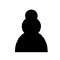
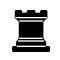
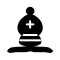
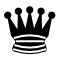
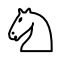
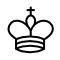
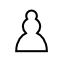
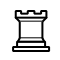
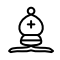
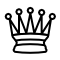
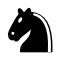
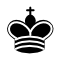

In [8]:
result = env.run(['Chess_bot_v2.py', 'random'])
print('Agent exit status/reward/time left: ')

for agent in result[-1]:
    print('\t', agent.status, '/', agent.reward, '/', agent.observation.remainingOverageTime)
print('\n')

env.render(mode='ipython', width=1000, height=1000)

# New Attempt

This attempt is stolen from Satya Prakash Swain, here is the kaggle link: https://www.kaggle.com/code/satyaprakashswain/the-knight-s-gambit-crafting-efficient-chess

In [9]:
%%writefile Chess_bot_v3.py

import time, random

EMPTY = '.'
PAWN = 'P'
KNIGHT = 'N'
BISHOP = 'B'
ROOK = 'R'
QUEEN = 'Q'
KING = 'K'

class ChessBoard:
    def __init__(self):
        self.board = [
            ['r', 'n', 'b', 'q', 'k', 'b', 'n', 'r'],
            ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'],
            ['.', '.', '.', '.', '.', '.', '.', '.'],
            ['.', '.', '.', '.', '.', '.', '.', '.'],
            ['.', '.', '.', '.', '.', '.', '.', '.'],
            ['.', '.', '.', '.', '.', '.', '.', '.'],
            ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
            ['R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R']
        ]
        self.current_player = 'white'

    def get_legal_moves(self):
        moves = []
        for i in range(8):
            for j in range(8):
                piece = self.board[i][j]
                if piece.isupper() == (self.current_player == 'white'):
                    moves.extend(self.get_piece_moves(i, j))
        return moves

    def get_piece_moves(self, row, col):
        piece = self.board[row][col].upper()
        moves = []

        if piece == PAWN:
            direction = -1 if self.current_player == 'white' else 1
            if 0 <= row + direction < 8 and self.board[row + direction][col] == EMPTY:
                moves.append((row, col, row + direction, col))
            elif piece == KNIGHT:
                knight_moves = [(-2, -1), (-2, 1), (-1, -2), (-1, 2), (1, 2), (2, -1), (2, 1)]
                for dr, dc in knight_moves:
                    r, c = row + dr, col + dc
                    if 0 <= r < 8 and 0 <= c < 8:
                        moves.append((row, col, r, c))
        return moves

    def make_move(self, move):
        from_row, from_col, to_row, to_col = move
        self.board[to_row][to_col] = self.board[from_row][from_col]
        self.board[from_row][from_col] = EMPTY
        self.current_player = 'black'if self.current_player == 'white' else 'white'

    def evaluate(self):
        piece_values = {PAWN: 1, KNIGHT: 3, BISHOP: 3, ROOK: 5, QUEEN: 9, KING: 0}
        score = 0
        for row in self.board:
            for piece in row:
                if piece.isupper():
                    score += piece_values.get(piece.upper(), 0)
                elif piece.islower():
                    score -= piece_values.get(piece.upper(), 0)
            return score

class EfficientChessAI:
    def __init__(self):
        self.max_depth = 3

    def get_move(self, board):
        best_move = None
        best_value = float('-inf')
        alpha = float('-inf')
        beta = float('inf')

        for move in board.get_legal_moves():
            board.make_move(move)
            value = self.minimax(board, self.max_depth - 1, alpha, beta, False)
            board.make_move(move[::-1])

            if value > best_value:
                best_value = value
                best_move = move

            if alpha >= beta:
                break

        return best_move

    def minimax(self, board, depth, alpha, beta, maximizing_player):
        if depth == 0:
            return board.evaluate()

        if maximizing_player:
            max_eval = float('-inf')
            for move in board.get_legal_moves():
                board.make_move(move)
                eval = self.minimax(board, depth - 1, alpha, beta, False)
                board.make_move(move[::-1])
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.get_legal_moves():
                board.make_move(move)
                eval = self.minimax(board, depth - 1, alpha, beta, True)
                board.make_move(move[::-1])
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

def agent(observation, configuration):
    board = ChessBoard()
    ai = EfficientChessAI()
    move = ai.get_move(board)

    return f"{chr(move[1] + 97)}{8 - move[0]}{chr(move[3] + 97)}{8 - move[2]}"

config = {
    'timeout': 1,
    'memory': 1024 * 1024 * 1024
}

def play_game():
    board = ChessBoard()
    ai = EfficientChessAI()
    while len(board.get_legal_moves()) > 0:
        move = ai.get_move(board)
        board.make_move(move)
        print_board(board)
        print('\n')
    print('Game Over')

def print_board(board):
    for row in board.board:
        print(' '.join(row))

if __name__ == '__main__':
    play_game()

Writing Chess_bot_v3.py


In [10]:
%%writefile Chess_bot_v3.py

import random
import time

# Chess piece representations
EMPTY = '.'
PAWN = 'P'
KNIGHT = 'N'
BISHOP = 'B'
ROOK = 'R'
QUEEN = 'Q'
KING = 'K'

class ChessBoard:
    def __init__(self):
        self.board = [
            ['r', 'n', 'b', 'q', 'k', 'b', 'n', 'r'],
            ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'],
            ['.', '.', '.', '.', '.', '.', '.', '.'],
            ['.', '.', '.', '.', '.', '.', '.', '.'],
            ['.', '.', '.', '.', '.', '.', '.', '.'],
            ['.', '.', '.', '.', '.', '.', '.', '.'],
            ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
            ['R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R']
        ]
        self.current_player = 'white'

    def get_legal_moves(self):
        moves = []
        for i in range(8):
            for j in range(8):
                piece = self.board[i][j]
                if piece.isupper() == (self.current_player == 'white'):
                    moves.extend(self.get_piece_moves(i, j))
        return moves

    def get_piece_moves(self, row, col):
        piece = self.board[row][col].upper()
        moves = []
        
        if piece == PAWN:
            direction = -1 if self.current_player == 'white' else 1
            if 0 <= row + direction < 8 and self.board[row + direction][col] == EMPTY:
                moves.append((row, col, row + direction, col))
        elif piece == KNIGHT:
            knight_moves = [(-2, -1), (-2, 1), (-1, -2), (-1, 2), (1, -2), (1, 2), (2, -1), (2, 1)]
            for dr, dc in knight_moves:
                r, c = row + dr, col + dc
                if 0 <= r < 8 and 0 <= c < 8:
                    moves.append((row, col, r, c))
        # Add more piece move logic here for other pieces

        return moves

    def make_move(self, move):
        from_row, from_col, to_row, to_col = move
        self.board[to_row][to_col] = self.board[from_row][from_col]
        self.board[from_row][from_col] = EMPTY
        self.current_player = 'black' if self.current_player == 'white' else 'white'

    def evaluate(self):
        piece_values = {PAWN: 1, KNIGHT: 3, BISHOP: 3, ROOK: 5, QUEEN: 9, KING: 0}
        score = 0
        for row in self.board:
            for piece in row:
                if piece.isupper():
                    score += piece_values.get(piece.upper(), 0)
                elif piece.islower():
                    score -= piece_values.get(piece.upper(), 0)
        return score

class EfficientChessAI:
    def __init__(self):
        self.max_depth = 3

    def get_move(self, board):
        best_move = None
        best_value = float('-inf')
        alpha = float('-inf')
        beta = float('inf')
        
        for move in board.get_legal_moves():
            board.make_move(move)
            value = self.minimax(board, self.max_depth - 1, alpha, beta, False)
            board.make_move(move[::-1])  # Undo move
            
            if value > best_value:
                best_value = value
                best_move = move
            
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        
        return best_move

    def minimax(self, board, depth, alpha, beta, maximizing_player):
        if depth == 0:
            return board.evaluate()
        
        if maximizing_player:
            max_eval = float('-inf')
            for move in board.get_legal_moves():
                board.make_move(move)
                eval = self.minimax(board, depth - 1, alpha, beta, False)
                board.make_move(move[::-1])  # Undo move
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.get_legal_moves():
                board.make_move(move)
                eval = self.minimax(board, depth - 1, alpha, beta, True)
                board.make_move(move[::-1])  # Undo move
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

def agent(observation, configuration):
    board = ChessBoard()
    # Update board state based on observation
    # This part depends on how the observation is structured in the Kaggle environment
    
    ai = EfficientChessAI()
    move = ai.get_move(board)
    
    # Convert move to the format expected by the Kaggle environment
    # This part also depends on how moves should be returned in the Kaggle environment
    return f"{chr(move[1] + 97)}{8 - move[0]}{chr(move[3] + 97)}{8 - move[2]}"

# Configuration for the Kaggle environment
config = {
    "timeout": 1,
    "memory": 1024 * 1024 * 1024,  # 1GB
}

# Example of how to run a game (for testing purposes)
def play_game():
    board = ChessBoard()
    ai = EfficientChessAI()
    while len(board.get_legal_moves()) > 0:
        move = ai.get_move(board)
        board.make_move(move)
        print_board(board)
        print("\n")
    print("Game Over")

def print_board(board):
    for row in board.board:
        print(' '.join(row))

if __name__ == "__main__":
    play_game()

Overwriting Chess_bot_v3.py


r
n
b
q
k
b
n
r
/
p
p
p
p
p
p
p
p
/
8
/
8
/
8
/
8
/
P
P
P
P
P
P
P
P
/
R
N
B
Q
K
B
N
R
 
w
 
K
Q
k
q
 
-
 
0
 
1
Agent exit status/reward/time left: 
	 ERROR / None / 10
	 DONE / 0 / 10





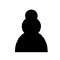
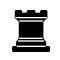
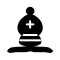
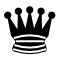
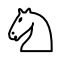
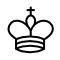
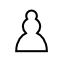
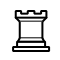
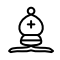
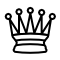
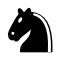
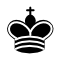

In [11]:
result = env.run(['Chess_bot_v3.py', 'random'])
print('Agent exit status/reward/time left: ')

for agent in result[-1]:
    print('\t', agent.status, '/', agent.reward, '/', agent.observation.remainingOverageTime)
print('\n')

env.render(mode='ipython', width=1000, height=1000)